<a href="https://colab.research.google.com/github/jensilathiya10/Face-Mask-Detection-YOLO-ResNet-MobileNet/blob/main/Face_Mask_Detection_YOLO_MobileNet_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install tensorflow opencv-python matplotlib --quiet
!pip install torch torchvision --quiet
!pip install ultralytics --upgrade --quiet  # for YOLOv5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 38.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found")


GPU memory growth enabled


In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enable memory growth if GPU found
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Simple tensor operation to trigger GPU
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.matmul(a, a)
print(b)


Num GPUs Available:  1
tf.Tensor(
[[ 7. 10.]
 [15. 22.]], shape=(2, 2), dtype=float32)


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2454305788260131
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2483945423990900419
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
from tensorflow.python.framework import test_util
from tensorflow.python.platform import build_info

print("CUDA version:", build_info.build_info.get('cuda_version', 'Unknown'))
print("cuDNN version:", build_info.build_info.get('cudnn_version', 'Unknown'))


CUDA version: 12.5.1
cuDNN version: 9


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/archive.zip" -d /content/dataset

In [ ]:
import xml.etree.ElementTree as ET

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Initialize variables for the image details
    label = None

    # Parse XML to get the label
    for member in root.findall('object'):
        label = member.find('name').text
        # Assuming we only need the label, not bounding box coordinates

    return label

In [ ]:
annotations_dir = '/content/dataset/annotations'
images_dir = '/content/dataset/images'

# Initialize lists to hold data
image_data = []
labels = []

# Loop over each XML file in the annotations folder
for xml_file in os.listdir(annotations_dir):
    if xml_file.endswith('.xml'):
        # Parse the XML to get the label
        xml_path = os.path.join(annotations_dir, xml_file)
        label = parse_xml(xml_path)

        # Corresponding image file
        image_file = xml_file.replace('.xml', '.png')
        image_path = os.path.join(images_dir, image_file)

        # Check if the image file exists
        if os.path.exists(image_path):
            # Read and resize image
            image = cv2.imread(image_path)
            image = cv2.resize(image, (128, 128))  # Resize to 128x128

            # Flatten the image for ANN
            image_flat = image.flatten()

            # Append data to lists
            image_data.append(image_flat)
            labels.append(label)

# Convert to numpy arrays
X = np.array(image_data)
y = np.array(labels)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

# Encode labels (e.g., 'with_mask' -> 0, 'without_mask' -> 1)
label_encoder = LabelBinarizer()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
y_encoded = np.array(y_encoded)

In [ ]:
# Convert y_encoded to categorical if it's binary and single-label
if len(y_encoded.shape) == 1:
    print("true")
    y_encoded = to_categorical(y_encoded)

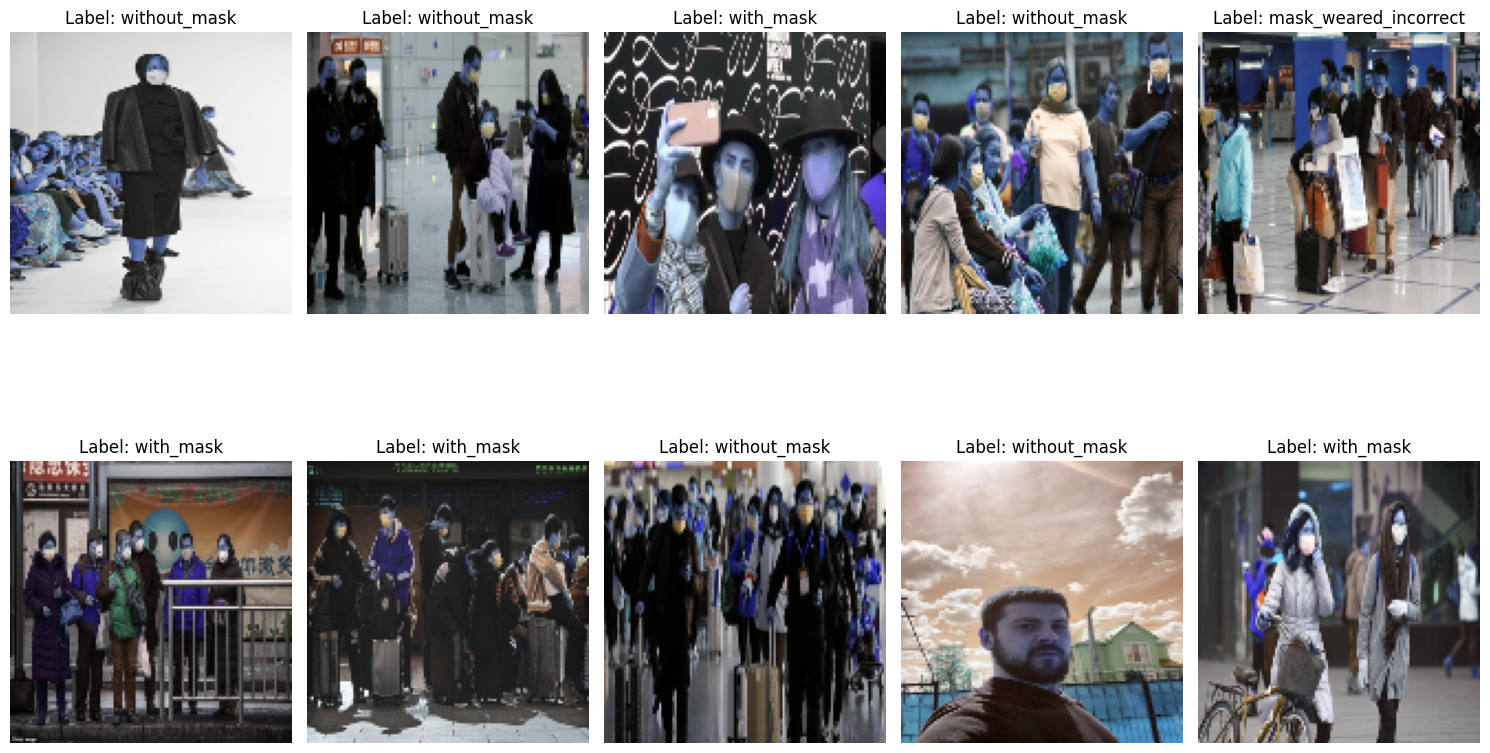

In [ ]:
from sklearn.preprocessing import LabelEncoder
import random

def visualize_images(X, y_encoded, label_encoder, num_images=10):
    plt.figure(figsize=(15, 10))
    indices = random.sample(range(len(X)), num_images)

    for i, idx in enumerate(indices):
        # Reshape the flattened image back to original dimensions
        image = X[idx].reshape(128, 128, 3)

        # Get the label index
        label_index = y_encoded[idx]

        # Decode the label
        label = label_encoder.inverse_transform([label_index])[0]

        # Plot each image in a grid
        plt.subplot(2, 5, i + 1)
        plt.imshow(image.astype('uint8'))
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Fit the label encoder and transform labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Call the visualization function
visualize_images(X, y_encoded, label_encoder, num_images=10)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Normalize pixel values to the range [0, 1]
X_normalized = X / 255.0

# One-hot encode labels for ANN
y_encoded_one_hot = to_categorical(y_encoded)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded_one_hot, test_size=0.2, random_state=42)

# Check the shape of the training and testing data
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (682, 49152), Training labels shape: (682, 3)
Testing data shape: (171, 49152), Testing labels shape: (171, 3)


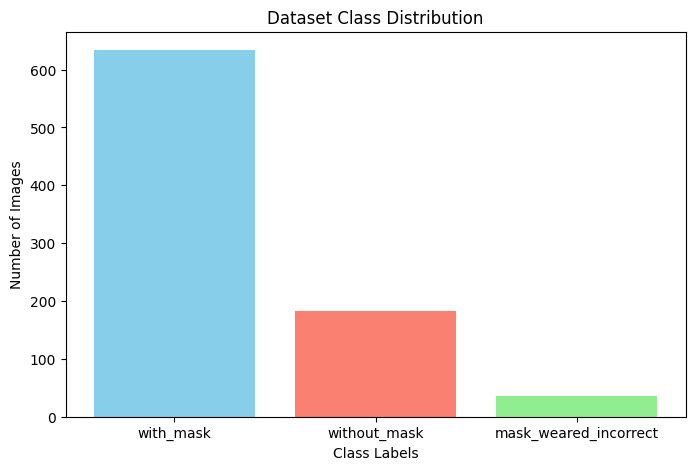

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count how many images per class
label_counts = Counter(y)

# Extract labels and counts
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(labels, counts, color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Dataset Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.show()


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Resize function to convert 128x128 images to 224x224
def resize_images(X, size=(224, 224)):
    X_resized = np.zeros((X.shape[0], size[0], size[1], 3), dtype=np.float32)
    for i in range(X.shape[0]):
        X_resized[i] = cv2.resize(X[i], size)
    return X_resized

# Reshape your data to have 4D shape first (batch, height, width, channels)
X_train_reshaped = X_train.reshape(-1, 128, 128, 3)
X_test_reshaped = X_test.reshape(-1, 128, 128, 3)

# Resize to 224x224
X_train_resized = resize_images(X_train_reshaped, (224, 224))
X_test_resized = resize_images(X_test_reshaped, (224, 224))

# Normalize images
X_train_resized /= 255.0
X_test_resized /= 255.0

# Build model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(y_train.shape[1], activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=output)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

model_resnet.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
resnet_history = model_resnet.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=10, batch_size=32)

# Save model
model_resnet.save('resnet_face_mask_model.h5')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 711ms/step - accuracy: 0.3485 - loss: 1.5299 - val_accuracy: 0.6842 - val_loss: 1.2056
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.5550 - loss: 1.0865 - val_accuracy: 0.6842 - val_loss: 1.0296
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.6074 - loss: 1.0754 - val_accuracy: 0.6842 - val_loss: 0.9468
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.6834 - loss: 0.8837 - val_accuracy: 0.6842 - val_loss: 0.8920
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.7131 - loss: 0.8480 - val_accuracy: 0.6842 - val_loss: 0.8558
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7222 - loss: 0.8054 - val_accuracy: 0.6842 - val_loss: 0.8321
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7170 - loss: 0.7657 - val_accuracy: 0.6842 - val_loss: 0.8176
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - a

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add custom layers on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(y_train.shape[1], activation='softmax')(x)  # Number of classes

# Create the full model
model_mobile = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model_mobile.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_mobile = model_mobile.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=10,
    batch_size=32
)

# Save the model
model_mobile.save("mobilenet_face_mask_model.h5")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4674 - loss: 1.4629 - val_accuracy: 0.6199 - val_loss: 1.1054
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6287 - loss: 1.0669 - val_accuracy: 0.6725 - val_loss: 1.0806
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6898 - loss: 0.8998 - val_accuracy: 0.6901 - val_loss: 1.0465
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7157 - loss: 0.8553 - val_accuracy: 0.6901 - val_loss: 1.0270
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6896 - loss: 0.9839 - val_accuracy: 0.6901 - val_loss: 1.0278
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6675 - loss: 0.9595 - val_accuracy: 0.6901 - val_loss: 1.0241
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6785 - loss: 0.8396 - val_accuracy: 0.6959 - val_loss: 1.0157
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 

In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report
import numpy as np

# Resize test data for ResNet50
X_test_resized_224 = tf.image.resize(X_test_reshaped, (224, 224)).numpy()

# Predict using both models
y_pred_mobile = model_mobile.predict(X_test_reshaped)
y_pred_resnet = model_resnet.predict(X_test_resized_224)

# Convert predictions and labels to class indices
y_pred_mobile_classes = np.argmax(y_pred_mobile, axis=1)
y_pred_resnet_classes = np.argmax(y_pred_resnet, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Class names
class_names = ['with_mask', 'without_mask', 'mask_weared_incorrect']

# Classification Reports
print("📊 MobileNetV2 Classification Report:")
print(classification_report(y_true_classes, y_pred_mobile_classes, target_names=class_names))

print("📊 ResNet50 Classification Report:")
print(classification_report(y_true_classes, y_pred_resnet_classes, target_names=class_names))


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 951ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 804ms/step
📊 MobileNetV2 Classification Report:
                       precision    recall  f1-score   support

            with_mask       0.00      0.00      0.00        11
         without_mask       0.71      0.99      0.83       117
mask_weared_incorrect       0.75      0.14      0.24        43

             accuracy                           0.71       171
            macro avg       0.49      0.38      0.35       171
         weighted avg       0.68      0.71      0.63       171

📊 ResNet50 Classification Report:
                       precision    recall  f1-score   support

            with_mask       0.00      0.00      0.00        11
         without_mask       0.68      1.00      0.81       117
mask_weared_incorrect       0.00      0.00      0.00        43

             accuracy                           0.68       171
            macro avg       0.23      0.33      0.27       171
         weighted avg      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report

# Ensure MobileNet input is (128, 128, 3)
X_test_mobile = X_test_reshaped  # Already (128,128,3)

# Resize for ResNet50 (224x224)
X_test_resnet = tf.image.resize(X_test_reshaped, (224, 224)).numpy()

# 1️⃣ Evaluate MobileNetV2
print("📊 Evaluating MobileNetV2:")
loss_mobile, acc_mobile = model_mobile.evaluate(X_test_mobile, y_test, verbose=0)
print(f"Loss: {loss_mobile:.4f}, Accuracy: {acc_mobile:.4f}")

# 2️⃣ Evaluate ResNet50
print("\n📊 Evaluating ResNet50:")
loss_resnet, acc_resnet = model_resnet.evaluate(X_test_resnet, y_test, verbose=0)
print(f"Loss: {loss_resnet:.4f}, Accuracy: {acc_resnet:.4f}")

# 3️⃣ Optional: Classification reports
y_pred_mobile = model_mobile.predict(X_test_mobile)
y_pred_resnet = model_resnet.predict(X_test_resnet)

y_pred_mobile_labels = np.argmax(y_pred_mobile, axis=1)
y_pred_resnet_labels = np.argmax(y_pred_resnet, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

class_names = ['with_mask', 'without_mask', 'mask_weared_incorrect']

print("\n🧾 MobileNetV2 Classification Report:")
print(classification_report(y_true_labels, y_pred_mobile_labels, target_names=class_names))

print("\n🧾 ResNet50 Classification Report:")
print(classification_report(y_true_labels, y_pred_resnet_labels, target_names=class_names))


📊 Evaluating MobileNetV2:
Loss: 0.9853, Accuracy: 0.7135

📊 Evaluating ResNet50:
Loss: 0.8204, Accuracy: 0.6842
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

🧾 MobileNetV2 Classification Report:
                       precision    recall  f1-score   support

            with_mask       0.00      0.00      0.00        11
         without_mask       0.71      0.99      0.83       117
mask_weared_incorrect       0.75      0.14      0.24        43

             accuracy                           0.71       171
            macro avg       0.49      0.38      0.35       171
         weighted avg       0.68      0.71      0.63       171


🧾 ResNet50 Classification Report:
                       precision    recall  f1-score   support

            with_mask       0.00      0.00      0.00        11
         without_mask       0.68      1.00      0.81       117
mask_weared_incorrect       0.00      0.00      0.00        43

             accuracy                    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name='Model'):
    acc = history.history.get('accuracy') or history.history.get('acc')
    val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Acc')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


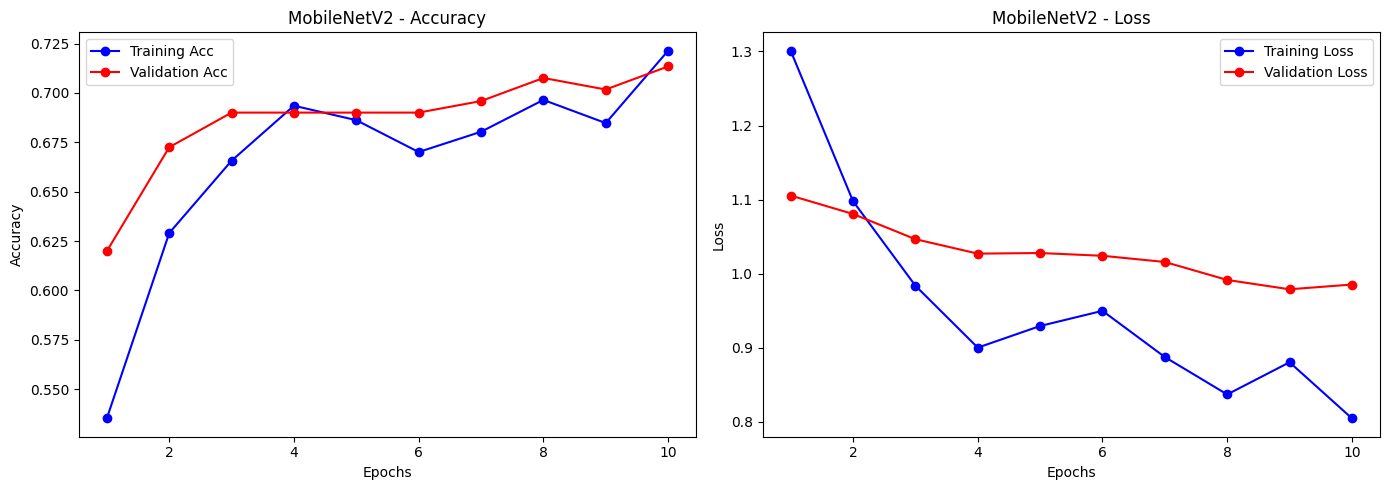

NameError: name 'history_resnet' is not defined

In [ ]:
plot_history(history_mobile, model_name='MobileNetV2')
plot_history(history_resnet, model_name='ResNet50')


In [ ]:
import os
import xml.etree.ElementTree as ET

# Paths
annotations_dir = '/content/dataset/annotations'
images_dir = '/content/dataset/images'
labels_dir = '/content/dataset/labels'  # We'll save YOLO txts here

os.makedirs(labels_dir, exist_ok=True)

# Your classes in order
classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

def convert_bbox(size, box):
    dw = 1.0 / size[0]
    dh = 1.0 / size[1]
    x = (box[0] + box[1]) / 2.0 - 1
    y = (box[2] + box[3]) / 2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    return x*dw, y*dh, w*dw, h*dh

for xml_file in os.listdir(annotations_dir):
    if not xml_file.endswith('.xml'):
        continue

    in_file = open(os.path.join(annotations_dir, xml_file))
    tree = ET.parse(in_file)
    root = tree.getroot()

    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    out_file = open(os.path.join(labels_dir, xml_file.replace('.xml', '.txt')), 'w')

    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls not in classes:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (
            float(xmlbox.find('xmin').text),
            float(xmlbox.find('xmax').text),
            float(xmlbox.find('ymin').text),
            float(xmlbox.find('ymax').text)
        )
        bb = convert_bbox((w,h), b)
        out_file.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")


In [ ]:
import shutil
import random

# Paths
train_img_dir = '/content/dataset/images/train'
val_img_dir = '/content/dataset/images/val'
train_label_dir = '/content/dataset/labels/train'
val_label_dir = '/content/dataset/labels/val'

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

all_images = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
random.shuffle(all_images)

split_ratio = 0.8
split_index = int(len(all_images) * split_ratio)

train_images = all_images[:split_index]
val_images = all_images[split_index:]

for img in train_images:
    shutil.copy(os.path.join(images_dir, img), train_img_dir)
    label_file = img.rsplit('.',1)[0] + '.txt'
    if os.path.exists(os.path.join(labels_dir, label_file)):
        shutil.copy(os.path.join(labels_dir, label_file), train_label_dir)

for img in val_images:
    shutil.copy(os.path.join(images_dir, img), val_img_dir)
    label_file = img.rsplit('.',1)[0] + '.txt'
    if os.path.exists(os.path.join(labels_dir, label_file)):
        shutil.copy(os.path.join(labels_dir, label_file), val_label_dir)


In [ ]:
yaml_content = """
train: /content/dataset/images/train
val: /content/dataset/images/val

nc: 3
names: ['with_mask', 'without_mask', 'mask_weared_incorrect']
"""

# Write the YAML content to a file
with open('/content/data.yaml', 'w') as file:
    file.write(yaml_content)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov5s.pt')  # Pretrained YOLOv5 small model

model.train(data='data.yaml', epochs=20, imgsz=640, batch=16)


In [ ]:
import xml.etree.ElementTree as ET
import os

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)

        bbox = obj.find('bndbox')
        x_min = int(bbox.find('xmin').text)
        y_min = int(bbox.find('ymin').text)
        x_max = int(bbox.find('xmax').text)
        y_max = int(bbox.find('ymax').text)

        boxes.append([x_min, y_min, x_max, y_max])

    return boxes, labels

annotations_dir = '/content/dataset/annotations'
ground_truth_boxes = []
ground_truth_labels = []

for xml_file in sorted(os.listdir(annotations_dir)):
    if xml_file.endswith('.xml'):
        boxes, labels = parse_annotation(os.path.join(annotations_dir, xml_file))
        ground_truth_boxes.append(boxes)
        ground_truth_labels.append(labels)


In [ ]:
print("Input to YOLO model:", yolo_input.shape)

In [ ]:
font_scale = 0.3
thickness = 0
def predict_and_draw_boxes(image_array, model, label_names, img_shape=(128,128,3)):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Reshape and prepare image
    image = image_array.reshape(img_shape)

    if image.dtype != np.uint8:
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)

    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    elif image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Predict
    results = model(image)
    result = results[0]

    # Extract bounding boxes, confidences, and class indices
    boxes = result.boxes.xyxy.cpu().numpy()       # (N, 4)
    scores = result.boxes.conf.cpu().numpy()      # (N,)
    classes = result.boxes.cls.cpu().numpy().astype(int)  # (N,)

    img = image.copy()

    # Draw each box and label
    for box, score, cls in zip(boxes, scores, classes):
        x_min, y_min, x_max, y_max = map(int, box)
        label = label_names[cls]
        if label == "without_mask":
            box_color = (0, 0, 255)       # Red color for bbox (BGR)
            bg_color = (0, 0, 255)        # Red background for label
            text_color = (255, 255, 255)  # White text on red bg
        else:
            box_color = (0, 255, 0)       # Green color for bbox
            bg_color = (0, 255, 0)        # Green background for label
            text_color = (0, 0, 0)

        # Draw rectangle
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), box_color, 2)

        # Text: label and confidence
        text = f"{label}: {score:.2f}"
        (text_width, text_height), baseline = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
        cv2.rectangle(img, (x_min, y_min - text_height - baseline), (x_min + text_width, y_min), box_color, -1,lineType=cv2.LINE_AA)
        cv2.putText(img, text, (x_min, y_min - baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), thickness)

    # Convert BGR to RGB for matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8),dpi=50)
    plt.imshow(img_rgb)
    plt.title("YOLO Predictions with Boxes and Labels")
    plt.axis('off')
    plt.show()


In [ ]:
idx = 7
predict_and_draw_boxes(X_test[idx], model, label_names, img_shape=(128,128,3))

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Path to the results image
img_path = 'runs/detect/train4/results.png'

# Load and display the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('YOLOv8 Training Curves')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cv2

# Path to the results image
img_path = 'runs/detect/train4/confusion_matrix.png'

# Load and display the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('YOLOv8 Training Curves')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cv2

# Path to the results image
img_path = 'runs/detect/train4/labels.jpg'

# Load and display the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('YOLO5 dataset')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import cv2

# Path to the results image
img_path = 'runs/detect/train4/train_batch432.jpg'

# Load and display the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('YOLOv5 samples')
plt.show()


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
